In [17]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file measures values and errors of 
# various Lyα profile parameters.

In [18]:
import os
import glob

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.stats import kendalltau, spearmanr

import sigfig
from sigfig import round as sf_round
#from to_precision import std_notation
import decimal

from astropy.cosmology import FlatLambdaCDM

from numba import njit

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec

In [ ]:
def measure():

    # Establish directories
    home = os.getcwd()
    data = home + '/data'

    '''
    files = np.array(['rest_sba-nonleaker-no_m3_MWdr.txt','rest_sba-leaker-no_m0_MWdr.txt',
                      'psz-arcslit-h3-comb1_MWdr.txt', 'psz-arcslit-h1-comb1_MWdr.txt',
                      'sunburst_M-6-comb1_MWdr.txt', 'psz-arcslit-h4-comb1_MWdr.txt',
                      'planckarc_pos1-comb1_MWdr.txt', 'psz-arcslit-h6-comb1_MWdr.txt',
                      'psz-arcslit-h9-comb1_MWdr.txt', 'psz-arcslit-f-comb1_MWdr.txt',
                      'psz-arcslit-h2-comb1_MWdr.txt'], dtype=object)
    names = np.array(['NL', 'L', 'M5', 'M4', 'M6', 'M3', 'M0', 'M2', 'M7', 'M8', 'M9'], dtype=str)
    '''

    slits = {
        'NL' : ['rest_sba-nonleaker-no_m3_MWdr.txt'],
        'L' : ['rest_sba-leaker-no_m0_MWdr.txt'],
        'M5' : ['psz-arcslit-m5-comb1_MWdr.txt'],
        'M4' : ['psz-arcslit-m4-comb1_MWdr.txt'],
        'M6' : ['psz-arcslit-m6-comb1_MWdr.txt'],
        'M3' : ['psz-arcslit-m3-comb1_MWdr.txt'],
        'M0' : ['psz-arcslit-m0-comb1_MWdr.txt'],
        'M2' : ['psz-arcslit-m2-comb1_MWdr.txt'],
        'M7' : ['psz-arcslit-m7-comb1_MWdr.txt'],
        'M8' : ['psz-arcslit-m8-comb1_MWdr.txt'],
        'M9' : ['psz-arcslit-m9-comb1_MWdr.txt']
    }

    f_esc = [2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    ne_esc = [0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    '''
    # For each file
    for i, file in enumerate(files):

        # Join its folder path to the file name
        file = ''.join([data, '/spectra/mage/', file])
        files[i] = file
    '''

    z = np.array([0, 0, 2.37086, 2.37073, 2.37021, 2.37025, 2.37014, 2.37017, 2.37044, 
                  2.37024, 2.37030], dtype=np.float64)
    c_peak_range = np.array([[60,140],[20,130],[0,100],[0,85],[10,130],[35,120],[10,130],
                             [45,125],[15,100],[25,125],[15,125]], dtype=np.float64)

    total_result = np.array([np.empty((9,1000))])

    mag = np.array([1.0, 1.0, 50.7, 14.6, 147.0, 36.1, 10.4, 31.6, 34.6, 29.4, 30.9], dtype=np.float64)

    R = np.array([
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 4700,
        299792.458 / 5300,
        299792.458 / 5200,
        299792.458 / 5200,
        299792.458 / 5500
    ])

    R_error = np.array([
        299792.458 / 5400**2 * 200,
        299792.458 / 5300**2 * 200,
        299792.458 / 5500**2 * 400,
        299792.458 / 5400**2 * 300,
        299792.458 / 5300**2 * 300,
        299792.458 / 5500**2 * 400,
        299792.458 / 4700**2 * 200,
        299792.458 / 5300**2 * 300,
        299792.458 / 5200**2 * 200,
        299792.458 / 5200**2 * 300,
        299792.458 / 5500**2 * 400
    ])

    # For each spectrum
    for i, slit_id in enumerate(slits):

        print(names[i])

        # Extract the data from the .txt file
        w, f, n = extract_data(f'{data}/spectra/mage/{slits[slit_id][0]})

        # Place the data in the rest frame
        w, f, n = rest_frame(w, f, n, z[i])

        f = f[(w >= 1195) & (w <= 1235)]
        n = n[(w >= 1195) & (w <= 1235)]
        w = w[(w >= 1195) & (w <= 1235)]

        v = 299792.458 * (w / 1215.67 - 1)

        fit_results, e_results, fcen_results, ratio_results, l_results = mc(w, v, f, n, z[i], c_peak_range[i], i)    

        median_fit = [np.median(e) for e in fit_results.T]

        # Take the transpose of the results so that the rows
        # are by parameter, not sample number
        #fit_results = fit_results.T

        if i in [0,2,3,4]:
            stdv_c_results = fit_results.T[6]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_r, _ = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                fwhm_c, _ = compute_fwhm_and_peak(sample[4], sample[5], sample[6], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

        else:
            stdv_c_results = fit_results.T[10]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_b, loc_b = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_b_results = np.append(fwhm_b_results, fwhm_b)

                fwhm_c, _ = compute_fwhm_and_peak(sample[8], sample[9], sample[10], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

                fwhm_r, loc_r = compute_fwhm_and_peak(sample[4], sample[5], sample[6], sample[7], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                vsep = abs(loc_r - loc_b)
                vsep_results = np.append(vsep_results, vsep)

        fwhm_c_results = fwhm_c_results[~np.isnan(fwhm_c_results)]

        # If the spectrum is one of the stacked spectra
        if i < 2:

            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]
            r = np.array([None,None,None,None,1,1,1])
            tau = np.array([None,None,None,None,1,1,1])
            rho = np.array([None,None,None,None,1,1,1])

        # If the spectrum is not one of the stacked spectra
        elif i > 1:

            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]
            r = np.array([None,None,None,None,1,1,1,1])
            tau = np.array([None,None,None,None,1,1,1,1])
            rho = np.array([None,None,None,None,1,1,1,1])

        # If the spectrum is not a stacked one
        if i > 1:
            # Create pseudo-measurements of the LyC escape fraction assuming the calculated value and standard deviation
            # correspond to a Gaussian mean and standard deviation
            fesc_results = np.random.normal(f_esc[i-2], ne_esc[i-2], 1000)

        else:
            fesc_results = np.empty(1000)
            fesc_results[:] = np.nan

        slit_result = np.array([np.empty(1000)])

        for j, result in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, fesc_results]):
            
            # Try to append any missing values as NaNs
            try:
                if len(result) < 1000:
                    a = np.empty(1000 - len(result))
                    a[:] = np.nan

                    result = np.append(result, a)

            # Unless the array has not been instantiated
            except TypeError:
                result = np.empty(1000)
                result[:] = np.nan
            
            if (i == 6) and (j == 7):
                result = np.empty(1000)
                result[:] = np.nan

            result = np.where(result != 0.0, result, np.nan)

            slit_result = np.append(slit_result, np.array([result]), axis=0)

        # Drop the first row since it is empty
        slit_result = slit_result[1:]

        total_result = np.append(total_result, np.array([slit_result]), axis=0)

    total_result = total_result[1:]

    r_locs = [[3,0,0,0,0,0,0,0],
        [2,4,0,0,0,0,0,0],
        [1,1,2,0,0,0,0,0],
        [3,3,2,7,0,0,0,0],
        [3,3,2,7,2,0,0,0],
        [3,3,2,7,2,2,1,1],
        [3,3,2,1,2,2,2,1],
        [2,'center left',2,4,2,2,2,2]]

    # For each row in the corner plot
    for i, row in enumerate(ax_c):

        # For each column in the corner plot
        for j, subplot in enumerate(row):

            r_results = np.array([], dtype=np.float64)
            tau_results = np.array([], dtype=np.float64)
            rho_results = np.array([], dtype=np.float64)

            # If the row / column pair is above the main diagonal
            if j > i:
                pass
            else:

                x_data = np.empty(1000)
                x_data[:] = np.nan
                x_data = np.array([x_data])
                y_data = np.empty(1000)
                y_data[:] = np.nan
                y_data = np.array([y_data])

                # For each spectrum
                for k, slit in enumerate(total_result):
                    
                    if all(np.isnan(slit[j])) or all(np.isnan(slit[i + 1])):
                        pass
                    else:

                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(y_data, np.array([slit[i + 1]]), axis=0)

                x_data = x_data[1:]
                y_data = y_data[1:]


                if (i==6) and (j==6):
                    pass

                for k, sample in enumerate(x_data[0]):

                    x = x_data[:,k]
                    y = y_data[:,k]

                    if any(np.isnan(x)) or any(np.isnan(y)):
                        pass
                    else:
                        x = x[x != 0]
                        y = y[y != 0]

                        r = np.corrcoef(x, y)[0,1]
                        tau = kendalltau(x, y).statistic
                        rho = spearmanr(x, y).statistic

                        r_results = np.append(r_results, r)
                        tau_results = np.append(tau_results, tau)
                        rho_results = np.append(rho_results, rho)

def plot():

def tabulate():

In [19]:
def extract_data(file):

    '''
    Extract spectrum from the .txt file

    Parameters:
        file : str
            Name of the file

    Returns:
        w : numpy.ndarray
            Observed wavelength bins
        f : numpy.ndarray
            Observed flux densities
        n : numpy.ndarray
            Observed Gaussian standard deviation of observed flux densities
    '''

    # Retrieve the data columns
    w, f, n = np.loadtxt(file, delimiter='\t', comments=('#', 'w'), usecols=(0,1,2), unpack=True)
    
    # If the file is not the stacked leaker spectrum. This step is necessary because 
    if 'leaker' not in file:

        # Remove bins of extreme outliers
        w = w[f < 1e-20]
        n = n[f < 1e-20]
        f = f[f < 1e-20]

        # Convert from units of erg/s/cm^2/Hz to erg/s/cm^2/Å
        f = f * 2.998e18 / np.square(w)
        n = n * 2.998e18 / np.square(w)

    return w, f, n    

@njit
def rest_frame(w, f, n, z):

    '''
    Place the data in the rest frame

    Parameters:
        w : numpy.ndarray
            Observed wavelength bins
        f : numpy.ndarray
            Observed flux densities
        n : numpy.ndarray
            Gaussian standard deviation of observed flux densities
        z : numpy.float64
            Redshift of the spectrum

    Returns:
        w : numpy.ndarray
            Rest wavelength bins
        f : numpy.ndarray
            Rest flux densities
        n : numpy.ndarray
            Gaussian standard deviation of rest flux densities
    '''

    w = w / (1 + z)
    f = f * (1 + z)
    n = n * (1 + z)

    return w, f, n

def compute_continuum(w, f):

    '''
    Compute the local continuum

    Parameters:
        w : numpy.ndarray
            Rest wavelength
        f : numpy.ndarray
            Rest flux density

    Returns:
        c : numpy.float64
            Local continuum flux density
    '''

    # Compute the local continuum as the
    # median flux density between 1221-1225 Å
    f = f[(w >= 1221) & (w <= 1225)]
    c = np.median(f)    

    return c

@njit
def compute_ew(w, f, c, results):

    '''
    Compute the EW of the Lyα profile

    Parameters:
        w : numpy.ndarray
            Rest wavelength
        f : numpy.ndarray
            Rest flux density
        c : numpy.float64
            Local continuum flux density
        results : numpy.ndarray
            Array containing measurements

    Returns:
        ew : numpy.float64
            Equivalent width
    '''

    # Compute the EW of the Lyα profile
    # between 1212-1221 Å
    f = f[(w >= 1212) & (w <= 1221)]
    w = w[(w >= 1212) & (w <= 1221)]
    ew = -1 * np.trapz(1 - f / c, w)

    results = np.append(results, ew)

    return results

@njit
def compute_fcen(v, f, results):

    '''
    '''

    # Compute the central escape fraction as a percent
    f_cen = np.trapz(f[(v >= -100) & (v <= 100)], v[(v >= -100) & (v <= 100)]) / np.trapz(f[(v >= -1000) & (v <= 1000)], v[(v >= -1000) & (v <= 1000)]) * 100
    results = np.append(results, f_cen)

    return results

def compute_l(w, f_mc, c, z, l_distance, l_results):

    f_mc = f_mc[(w >= 1212 * (1 + z)) & ((w <= 1221 * (1 + z)))]
    w = w[(w >= 1212 * (1 + z)) & ((w <= 1221 * (1 + z)))]

    flux = np.trapz(f_mc - c, w)

    l = 4 * np.pi * flux * l_distance**2
    l_results = np.append(l_results, l)

    return l_results


def compute_ratio(v, f_mc, c, c_peak_range, ratio_results):

    '''
    '''

    ratio = np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) / c
    ratio_results = np.append(ratio_results, ratio)

    return ratio_results

def fit_peaks(v, f_mc, c, c_peak_range, model, i):

    '''
    '''

    # If there is no blue peak
    if i in [0,3,4]:
        
        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,c)
        bounds = ([0,0,0,0,0,0,0,0],[np.amax(f_mc),1000,np.inf,np.inf,np.amax(f_mc),200,85,np.mean(f_mc)])
    
    elif i in [2]:

        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - c,50,20,c)
        bounds = ([0,0,0,0,0,0,0,0],[np.amax(f_mc),500,np.inf,np.inf,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]) - c,100,40,np.amax(f_mc)])

    # Otherwise
    else:

        # Assign the initial guess and parameter bounds; this must be done inside the Monte Carlo loop to get the best initial
        # estimates so they can be built from the random sample
        p0 = (np.amax(f_mc[(v >= -1000) & (v <= 0)]),-150,20,-1,np.amax(f_mc[(v >= 150) & (v <= 1000)]),200,20,1,np.amax(f_mc[(v >= c_peak_range[0]) & (v <= c_peak_range[1])]),80,40,c)
        bounds = ([0,-1000,0,-np.inf,0,0,0,0,0,0,0,0],[np.amax(f_mc[(v >= -1000) & (v <= 0)]),0,np.inf,0,np.amax(f_mc),1000,np.inf,np.inf,np.amax(f_mc),200,85,np.mean(f_mc)])

    p, cov = curve_fit(model, v, f_mc, p0=p0, bounds=bounds, maxfev=2000)

    return p, cov

def mc(w, v, f, n, z, c_peak_range, i):

    '''
    Parameters:
        w : numpy.ndarray
        f : numpy.ndarray
        n : numpy.ndarray
    '''

    def two_peaks(x, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    def three_peaks(x, amp_b, cen_b, width_b, skew_b, amp_r, cen_r, width_r, skew_r, amp_c, cen_c, width_c, cntm):

        return amp_b * np.exp(-((x - cen_b) / width_b)**2 / 2) * (1 + erf(skew_b * ((x - cen_b) / width_b) / np.sqrt(2)))  \
            + amp_r * np.exp(-((x - cen_r) / width_r)**2 / 2) * (1 + erf(skew_r * ((x - cen_r) / width_r) / np.sqrt(2))) \
            + amp_c * np.exp(-((x - cen_c) / width_c)**2 / 2) \
            + cntm

    cosmology=FlatLambdaCDM(70,0.3)
    l_distance = cosmology.luminosity_distance(z).value * 3.086e24

    # If there is no blue peak
    if i in [0,2,3,4]:
        model = two_peaks
        fit_results = np.empty((1,8), dtype=np.float64)
    
    # Otherwise
    else:
        model = three_peaks
        fit_results = np.empty((1,12), dtype=np.float64)

    if i > 1:
        f = f * 1e17
        n = n * 1e17

    mag = np.array([1.0, 1.0, 50.7, 14.6, 147.0, 36.1, 10.4, 31.6, 34.6, 29.4, 30.9], dtype=np.float64)

    e_results = np.array([], dtype=np.float64)
    fcen_results = np.array([], dtype=np.float64)
    l_results = np.array([], dtype=np.float64)
    ratio_results = np.array([], dtype=np.float64)

    for s in range(1000):

        f_mc = np.random.normal(f, n)

        c = compute_continuum(w, f_mc)

        e_results = compute_ew(w, f_mc, c, e_results)

        fcen_results = compute_fcen(v, f_mc, fcen_results)

        l_results = compute_l(w * (1 + z), f_mc * 1e-17 / (1 + z) / mag[i], c * 1e-17 / (1 + z) / mag[i], z, l_distance, l_results)    

        #ratio_results = compute_ratio(v, f_mc, c, c_peak_range, ratio_results)

        try:

            p, _ = fit_peaks(v[(v >= -1000) & (v <= 1000) & (f_mc >= c)], f_mc[(v >= -1000) & (v <= 1000) & (f_mc >= c)], c, c_peak_range, model, i)
            
            ratio_results = np.append(ratio_results, p[-4] / p[-1])
            
            fit_results = np.append(fit_results, np.array([p]), axis=0)

            '''
            if i==0:

                fig, ax = plt.subplots()  

                ax.plot(v, f_mc, ds='steps-mid', color='black')
                ax.plot(v, model(v, *p), ls='dashed', color='red')
                ax.set_xlim(-1000,1000)
                plt.show()
            '''

        except RuntimeError:
            pass

    # Remove the first empty row that was created
    # when the array was initialized
    fit_results = fit_results[1:]

    for i, parameter in enumerate(fit_results.T):

        #print(f'$np.median(parameter)_-{abs(np.median(parameter) - np.percentile(parameter, 16))}r}^r{+{abs(np.percentile(parameter, 84) - np.median(parameter))}r}$')
        print('$' + str(np.median(parameter)) + \
            '_{-' + str(sf_round(abs(np.median(parameter) - np.percentile(parameter, 16)),1)) + '}' + \
            '^{+' + str(sf_round(abs(np.percentile(parameter, 84) - np.median(parameter)),1)) + '}' + \
            '$')

    return fit_results, e_results, fcen_results, ratio_results, l_results

def compute_fwhm_and_peak(amp, cen, width, skew, R, R_error):

    '''
    Returns:
        fwhm : numpy.float64
        loc : numpy.float64
    '''
    def lin_interp(x, y, i, half):
        return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

    def model(x, amp, cen, width, skew):

        return amp * np.exp(-((x - cen) / width)**2 / 2) * (1 + erf(skew * ((x - cen) / width) / np.sqrt(2)))

    v = np.arange(-1000,1000,0.1)

    peak = model(v, amp, cen, width, skew)    

    loc = v[np.argmax(peak)]

    half = np.amax(peak) / 2.0
    signs = np.sign(np.add(peak, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]

    fwhm = abs(lin_interp(v, peak, zero_crossings_i[0], half) - lin_interp(v, peak, zero_crossings_i[1], half))

    res = np.random.normal(R, R_error)

    fwhm = np.sqrt((fwhm)**2 - (res)**2)

    return fwhm, loc

def label(fig, ax, fig_stack, ax_stack):

    slits = np.array(['M5','M4','M6','M3','M0','M2','M7','M8','M9'], dtype=str)    

    for i, row in enumerate(ax):

        row[-1].yaxis.set_label_position('right')
        row[-1].set_ylabel(slits[i], rotation=-90, labelpad=10)

    ax_stack[0,6].yaxis.set_label_position('right')
    ax_stack[0,6].set_ylabel('NL', rotation=-90, labelpad=10)

    ax_stack[1,6].yaxis.set_label_position('right')
    ax_stack[1,6].set_ylabel('L', rotation=-90, labelpad=10)

    ax[3,0].set_title(r'$v_{\rm{sep}}$')
    ax[3,1].set_title('FWHM (blue)')
    ax[0,2].set_title('FWHM (center)')
    ax[0,3].set_title('FWHM (red)')
    ax[0,4].set_title(r'$f_{\rm{min}}/f_{\rm{cont}}$')
    ax[0,5].set_title('EW')
    ax[0,6].set_title(r'$f_{\rm{cen}}$')
    ax[0,7].set_title('Luminosity')
    
    ax_stack[1,0].set_title(r'$v_{\rm{sep}}$')
    ax_stack[1,1].set_title('FWHM (blue)')
    ax_stack[0,2].set_title('FWHM (center)')
    ax_stack[0,3].set_title('FWHM (red)')
    ax_stack[0,4].set_title(r'$f_{\rm{min}}/f_{\rm{cont}}$')
    ax_stack[0,5].set_title('EW')
    ax_stack[0,6].set_title(r'$f_{\rm{cen}}$')

    xlabels = np.array(['(km s$^{-1}$)','(km s$^{-1}$)','(km s$^{-1}$)',
        '(km s$^{-1}$)','',r'($\rm{\AA}$)','(%)','(10$^{42}$ erg s$^{-1}$)'], dtype=str)

    for i, column in enumerate(ax.T):

        ax[8,i].set_xlabel(xlabels[i])

    for i, column in enumerate(ax_stack.T):

        ax_stack[1,i].set_xlabel(xlabels[i])

    fig.supxlabel(r'$x-\mu$')
    fig.supylabel('Count')

    fig_stack.supxlabel(r'$x-\mu$')
    fig_stack.supylabel('Count')

def set_ticks(ax, ax_stack):

    for i, row in enumerate(ax):

        for j, column in enumerate(row):

            if j == 7:
                ax[i,j].tick_params(bottom=True, left=True, right=False)

            else:
                ax[i,j].tick_params(bottom=True, left=True, right=True)

    ax[0,2].tick_params(labelleft=True)
    ax[1,2].tick_params(labelleft=True)
    ax[2,2].tick_params(labelleft=True)

    for i, row in enumerate(ax_stack):

        for j, column in enumerate(row):

            if j == 6:
                ax_stack[i,j].tick_params(bottom=True, left=True, right=False)

            else:
                ax_stack[i,j].tick_params(bottom=True, left=True, right=True)

    ax_stack[0,2].tick_params(labelleft=True)

def disable_plots(ax, ax_stack):

    ax_stack[0,0].axis('off')    
    ax_stack[0,1].axis('off')    

    for i in [0,1,2]:

        ax[i,0].axis('off')
        ax[i,1].axis('off')

def make_corner_plot():

    '''
    '''

    fig, ax = plt.subplots(8,8, figsize=(16,16), sharex='col', sharey='row', constrained_layout=True)
    fig.tight_layout()

    for i, row in enumerate(ax):

        for j, subplot in enumerate(row):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

            if j > i:
                ax[i,j].axis('off')
    
    #ax[0,0].set_aspect(1 / subplot.get_data_ratio(), adjustable='datalim')
    #ax_dummy = fig.add_axes(ax[0,0].get_position())

    #ax_dummy = ax[0,0].twinx()    
    #ax_dummy.set_aspect('equal')

    #row_titles = np.array(['FWHM(center)','FWHM (red)',r'$f_{\rm{min}}/f_{\rm{cont}}$','EW',r'$f_{\rm{cen}}$','Luminosity',r'$f_{\rm{esc}}^{\rm{LyC}}$'], dtype=str)

    row_titles = np.array(['FWHM (blue)', 'FWHM (center)', 'FWHM (red)', 
        r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', r'$f_{\rm{cen}}$',
        'Luminosity', r'$f_{\rm{esc}}^{\rm{LyC}}$'], dtype=str)
    column_titles = np.array([r'$v_{\rm{sep}}$', 'FWHM (blue)', 'FWHM (center)',
        'FWHM (red)', r'$f_{\rm{min}}/f_{\rm{cont}}$', 'EW', 
        r'$f_{\rm{cen}}$', 'Luminosity'], dtype=str)
    column_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)',
        '(km s$^{-1}$)', '', r'($\rm{\AA}$)',
        '(%)', '(10$^{42}$ erg s$^{-1}$)'], dtype=str)
    row_labels = np.array(['(km s$^{-1}$)', '(km s$^{-1}$)', '(km s$^{-1}$)',
        '', r'($\rm{\AA}$)', '(%)', '(10$^{42}$ erg s$^{-1}$)', '(%)'], dtype=str)

    for i, row in enumerate(ax):

        ax[i,0].set_ylabel(row_titles[i], fontsize='large')
        ax[i,i].set_title(column_titles[i])

        ax[7,i].set_xlabel(column_labels[i], fontsize='large')

        if i > 0:
            ax[i,i].yaxis.set_label_position('right')
            ax[i,i].set_ylabel(row_labels[i], fontsize='large')

    for i, row in enumerate(ax):

        for j, subplot in enumerate(row):

            # Subplots on the interior
            if ((i != j) & (i != 7) & (j != 0)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')

            # Subplots on the main diagonal but not the corners
            elif ((i == j) & (i != 7) & (j != 0)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=True, labelbottom=False, labeltop=False, direction='in')
            
            # Subplots on the left column but not the corners
            elif ((j == 0) & (i != 0) & (i != 7)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')

            # Subplots on the bottom row but not the corners
            elif ((i == 7) & (j != 0) & (j != 7)):
                subplot.tick_params(left=True, right=True, bottom=True, top=True,
                    labelleft=False, labelright=False, labelbottom=True, labeltop=False, direction='in')

    ax[0,0].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=False, labelbottom=False, labeltop=False, direction='in')
    ax[7,0].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=False, labelbottom=True, labeltop=False, direction='in')
    ax[7,7].tick_params(left=True, right=True, bottom=True, top=True,
        labelleft=False, labelright=True, labelbottom=True, labeltop=False, direction='in')

    return fig, ax

def gaussian(x, amp, cen, width):
    return amp * np.exp(-((x - cen) / width)**2 / 2)

def skewed_gaussian(x, amp, cen, width, skew):
    return amp * np.exp(-((x - cen) / width)**2 / 2) * (1 + erf(skew * ((x - cen) / width) / np.sqrt(2)))

def measure():

    # Establish directories
    home = os.getcwd()
    data = home + '/data'
    figs = home + '/figs'

    #files = glob.glob(data + '/spectra/mage/*MWdr.txt')

    files = np.array(['rest_sba-nonleaker-no_m3_MWdr.txt','rest_sba-leaker-no_m0_MWdr.txt',
                      'psz-arcslit-h3-comb1_MWdr.txt', 'psz-arcslit-h1-comb1_MWdr.txt',
                      'sunburst_M-6-comb1_MWdr.txt', 'psz-arcslit-h4-comb1_MWdr.txt',
                      'planckarc_pos1-comb1_MWdr.txt', 'psz-arcslit-h6-comb1_MWdr.txt',
                      'psz-arcslit-h9-comb1_MWdr.txt', 'psz-arcslit-f-comb1_MWdr.txt',
                      'psz-arcslit-h2-comb1_MWdr.txt'], dtype=object)
    names = np.array(['NL', 'L', 'M5', 'M4', 'M6', 'M3', 'M0', 'M2', 'M7', 'M8', 'M9'], dtype=str)

    f_esc = [2.3, -0.6, 3, 2.3, 17, 18, 12, 15, 14]
    ne_esc = [0.8, 0.2, 1, 0.8, 6, 7, 5, 6, 5]

    # For each file
    for i, file in enumerate(files):

        # Join its folder path to the file name
        file = ''.join([data, '/spectra/mage/', file])
        files[i] = file

    z = np.array([0, 0, 2.37086, 2.37073, 2.37021, 2.37025, 2.37014, 2.37017, 2.37044, 
                  2.37024, 2.37030], dtype=np.float64)
    c_peak_range = np.array([[60,140],[20,130],[0,100],[0,85],[10,130],[35,120],[10,130],
                             [45,125],[15,100],[25,125],[15,125]], dtype=np.float64)

    fig_mc, ax_mc = plt.subplots(9,8, figsize=(16,18), sharey='row', constrained_layout=True)
    fig_mc_stack, ax_mc_stack = plt.subplots(2,7, figsize=(21,6), sharey='row', constrained_layout=True)

    fig_lya, ax_lya = plt.subplots(3,3, figsize=(12,12), sharex=True, constrained_layout=True)
    ax_lya_array = np.array(ax_lya).reshape(-1)

    fig_lya_stack, ax_lya_stack = plt.subplots(3,1, figsize=(3,9), sharex=True)#, constrained_layout=True)
    #fig_lya_stack.subplots_adjust(hspace=0, wspace=0)

    fig_c, ax_c = make_corner_plot()

    total_result = np.array([np.empty((9,1000))])

    mag = np.array([1.0, 1.0, 50.7, 14.6, 147.0, 36.1, 10.4, 31.6, 34.6, 29.4, 30.9], dtype=np.float64)

    R = np.array([
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 5400,
        299792.458 / 5300,
        299792.458 / 5500,
        299792.458 / 4700,
        299792.458 / 5300,
        299792.458 / 5200,
        299792.458 / 5200,
        299792.458 / 5500
    ])

    R_error = np.array([
        299792.458 / 5400**2 * 200,
        299792.458 / 5300**2 * 200,
        299792.458 / 5500**2 * 400,
        299792.458 / 5400**2 * 300,
        299792.458 / 5300**2 * 300,
        299792.458 / 5500**2 * 400,
        299792.458 / 4700**2 * 200,
        299792.458 / 5300**2 * 300,
        299792.458 / 5200**2 * 200,
        299792.458 / 5200**2 * 300,
        299792.458 / 5500**2 * 400
    ])

    # For each spectrum
    for i, file in enumerate(files):

        print(names[i])

        # Extract the data from the .txt file
        w, f, n = extract_data(file)

        # Place the data in the rest frame
        w, f, n = rest_frame(w, f, n, z[i])

        f = f[(w >= 1195) & (w <= 1235)]
        n = n[(w >= 1195) & (w <= 1235)]
        w = w[(w >= 1195) & (w <= 1235)]

        v = 299792.458 * (w / 1215.67 - 1)

        #cosmology = FlatLambdaCDM(70, 0.3)
        #l_distance = cosmology.luminosity_distance(z[i]).value * 3.086e24

        fit_results, e_results, fcen_results, ratio_results, l_results = mc(w, v, f, n, z[i], c_peak_range[i], i)    

        median_fit = [np.median(e) for e in fit_results.T]

        # Take the transpose of the results so that the rows
        # are by parameter, not sample number
        #fit_results = fit_results.T

        if i in [0,2,3,4]:
            stdv_c_results = fit_results.T[6]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_r, _ = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                fwhm_c, _ = compute_fwhm_and_peak(sample[4], sample[5], sample[6], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

        else:
            stdv_c_results = fit_results.T[10]
            fwhm_c_results = 2 * np.sqrt(2 * np.log(2)) * stdv_c_results

            fwhm_b_results = np.array([], dtype=np.float64)
            fwhm_c_results = np.array([], dtype=np.float64)
            fwhm_r_results = np.array([], dtype=np.float64)
            vsep_results = np.array([], dtype=np.float64)

            for j, sample in enumerate(fit_results):

                fwhm_b, loc_b = compute_fwhm_and_peak(sample[0], sample[1], sample[2], sample[3], R[i], R_error[i])
                fwhm_b_results = np.append(fwhm_b_results, fwhm_b)

                fwhm_c, _ = compute_fwhm_and_peak(sample[8], sample[9], sample[10], 0, R[i], R_error[i])
                fwhm_c_results = np.append(fwhm_c_results, fwhm_c)

                if np.isnan(fwhm_c):
                    print(i, fwhm_c)

                fwhm_r, loc_r = compute_fwhm_and_peak(sample[4], sample[5], sample[6], sample[7], R[i], R_error[i])
                fwhm_r_results = np.append(fwhm_r_results, fwhm_r)

                vsep = abs(loc_r - loc_b)
                vsep_results = np.append(vsep_results, vsep)

        fwhm_c_results = fwhm_c_results[~np.isnan(fwhm_c_results)]

        # If the spectrum is one of the stacked spectra
        if i < 2:

            if i == 0:
                color='#DC3220'
                markersize = 8
            else:
                color='#005AB5'
                markersize = 8

            ax_mc_stack[i,0].hist(vsep_results - np.median(vsep_results), bins=30, color=color)
            ax_mc_stack[i,1].hist(fwhm_b_results - np.median(fwhm_b_results), bins=30, color=color)
            ax_mc_stack[i,2].hist(fwhm_c_results - np.median(fwhm_c_results), bins=30, color=color)
            ax_mc_stack[i,3].hist(fwhm_r_results - np.median(fwhm_r_results), bins=30, color=color)
            ax_mc_stack[i,4].hist(ratio_results - np.median(ratio_results), bins=30, color=color)
            ax_mc_stack[i,5].hist(e_results - np.median(e_results), bins=30, color=color)
            ax_mc_stack[i,6].hist(fcen_results - np.median(fcen_results), bins=30, color=color)

            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]
            r = np.array([None,None,None,None,1,1,1])
            tau = np.array([None,None,None,None,1,1,1])
            rho = np.array([None,None,None,None,1,1,1])

            # For each subplot in a row
            for j, subplot in enumerate(ax_mc_stack[i]):

                try:

                    median = np.median(results[j][~np.isnan(results[j])])
                    lower = sigfig.round(str(median - np.percentile(results[j][~np.isnan(results[j])], 16)), 2)
                    upper = sigfig.round(str(np.percentile(results[j][~np.isnan(results[j])], 84) - median), 2)

                    # If both percentiles are greater than 10, they will not have
                    # any significant figures past the decimal place
                    if abs(float(lower)) >= 10 and abs(float(upper)) >= 10:
                        # Find the smallest value between the two percentiles
                        string = str(np.amin([int(lower), int(upper)]))

                        # Count the number of zeros in the string
                        zeros = string.count('0')

                        # If the length of the string differs by only one from
                        # the number of zeros, this indicates one of the 2 
                        # significant figures is a zero, so to prevent the median
                        # from being rounded prematurely (to the significant figure
                        # before the zero), subtract the number of zeros by one
                        if len(string) == zeros + 1:
                            zeros = zeros - 1

                        zeros = -1 * zeros

                        median = str(int(round(median, zeros)))

                    elif (abs(float(lower)) >= 10 and abs(float(upper)) < 10) or (abs(float(lower)) < 10 and abs(float(upper)) >= 10):
                        print('check')

                        if abs(float(lower)) >= 10:
                            median = str(round(median, len(upper.split('.')[1])))
                        if abs(float(upper)) >= 10:
                            median = str(round(median, len(lower.split('.')[1])))
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        #median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    # Otherwise, since the percentiles are rounded to 2 significant
                    # figures, they will have at least one significant digit past
                    # the decimal place
                    else:
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    at = AnchoredText('$' + median + '_{-' + lower + '}^{+' + upper + '}$',
                        loc='upper right', frameon=False)
                    subplot.add_artist(at)

                # Except if there are no results for the parameter
                # (because it was inapplicable to the profile)
                except IndexError:
                    pass

            ax_lya_stack[0].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
            ax_lya_stack[0].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)

            for j, result_row in enumerate([fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):
                
                # If this is the stacked nonleaker spectrum
                if i == 0:
                    if j == 0:
                        pass
                    else:
                        for k, result_col in enumerate([fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):
                            
                            if k + 2 > j:
                                pass
                            else:
                                ax_c[j,k+2].errorbar(np.median(result_col), np.median(result_row), 
                                    xerr=[[np.median(result_col) - np.percentile(result_col, 16)], [np.percentile(result_col, 84) - np.median(result_col)]], 
                                    yerr=[[np.median(result_row) - np.percentile(result_row, 16)], [np.percentile(result_row, 84) - np.median(result_row)]],
                                    lw=1, marker='s', markersize=markersize, mec=color, mfc=color, ecolor=color)
                else:
                    for k, col in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results]):

                        if k > j:
                            pass
                        else:
                            ax_c[j,k].errorbar(np.median(col), np.median(result_row),
                                xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                yerr=[[np.median(result_row) - np.percentile(result_row, 16)], [np.percentile(result_row, 84) - np.median(result_row)]],
                                lw=1, marker='o', markersize=markersize, mec=color, mfc=color, ecolor=color)

            if i == 0:

                ax_lya_stack[1].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4], median_fit[5], median_fit[6]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[1].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4], median_fit[5], median_fit[6]) + skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            else:

                ax_lya_stack[2].fill_between(v[(v >= -1100) & (v <= 1100)], (f - 3 * n)[(v >= -1100) & (v <= 1100)], (f + 3 * n)[(v >= -1100) & (v <= 1100)], step='mid', facecolor=color, alpha=0.3)
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)], f[(v >= -1100) & (v <= 1100)], ds='steps-mid', c=color)
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8], median_fit[9], median_fit[10]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[4], median_fit[5], median_fit[6], median_fit[7]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_stack[2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8], median_fit[9], median_fit[10]) + skewed_gaussian(v, median_fit[4], median_fit[5], median_fit[6], median_fit[7]) + skewed_gaussian(v, median_fit[0], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

        # If the spectrum is not one of the stacked spectra
        elif i > 1:

            if i in [2,3,4]:
                color='#DC3220'
                marker = 's'
                markersize = 8

            elif i == 5:
                color='#D35FB7'
                marker = '*'
                markersize = 10

            else:
                color='#005AB5'
                marker = 'o'
                markersize = 8

            ax_mc[i-2,0].hist(vsep_results - np.median(vsep_results), bins=30, color=color)
            ax_mc[i-2,1].hist(fwhm_b_results - np.median(fwhm_b_results), bins=30, color=color)
            ax_mc[i-2,2].hist(fwhm_c_results - np.median(fwhm_c_results), bins=30, color=color)
            ax_mc[i-2,3].hist(fwhm_r_results - np.median(fwhm_r_results), bins=30, color=color)
            ax_mc[i-2,4].hist(ratio_results - np.median(ratio_results), bins=30, color=color)
            ax_mc[i-2,5].hist(e_results - np.median(e_results), bins=30, color=color)
            ax_mc[i-2,6].hist(fcen_results - np.median(fcen_results), bins=30, color=color)
            ax_mc[i-2,7].hist((l_results - np.median(l_results)) * 1e-42, bins=30, color=color)
            
            results = [vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]
            r = np.array([None,None,None,None,1,1,1,1])
            tau = np.array([None,None,None,None,1,1,1,1])
            rho = np.array([None,None,None,None,1,1,1,1])

            # For each subplot in a row
            for j, subplot in enumerate(ax_mc[i-2]):

                try:

                    #median = np.median(results[j])
                    #lower = median - np.percentile(results[j], 16)
                    #upper = np.percentile(results[j], 84) - median

                    median = np.median(results[j][~np.isnan(results[j])])
                    lower = sigfig.round(str(median - np.percentile(results[j][~np.isnan(results[j])], 16)), 2)
                    upper = sigfig.round(str(np.percentile(results[j][~np.isnan(results[j])], 84) - median), 2)

                    #print(median, lower, upper)

                    # If both percentiles are greater than 10, they will not have
                    # any significant figures past the decimal place
                    if abs(float(lower)) >= 10 and abs(float(upper)) >= 10:
                        # Find the smallest value between the two percentiles
                        string = str(np.amin([int(lower), int(upper)]))

                        # Count the number of zeros in the string
                        zeros = string.count('0')

                        # If the length of the string differs by only one from
                        # the number of zeros, this indicates one of the 2 
                        # significant figures is a zero, so to prevent the median
                        # from being rounded prematurely (to the significant figure
                        # before the zero), subtract the number of zeros by one
                        if len(string) == zeros + 1:
                            zeros = zeros - 1

                        zeros = -1 * zeros

                        median = str(int(round(median, zeros)))
                    
                    elif (abs(float(lower)) >= 10 and abs(float(upper)) < 10) or (abs(float(lower)) < 10 and abs(float(upper)) >= 10):
                        print('check')
                        
                        if abs(float(lower)) >= 10:
                            formatter = '{:.' + str(len(upper.split('.')[1])) + 'f}'
                            median = formatter.format(round(median, len(upper.split('.')[1])))
                        if abs(float(upper)) >= 10:
                            formatter = '{:.' + str(len(lower.split('.')[1])) + 'f}'
                            median = formatter.format(round(median, len(lower.split('.')[1])))
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        #median = str(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    # Otherwise, since the percentiles are rounded to 2 significant
                    # figures, they will have at least one significant digit past
                    # the decimal place
                    else:
                        # Round the median to the smallest digit place between the upper and lower percentiles   
                        formatter = '{:.' + str(np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])) + 'f}'
                        median = formatter.format(round(median, np.amax([len(lower.split('.')[1]), len(upper.split('.')[1])])))

                    #at = AnchoredText('$' + str(round(median, r[j])) + '_{-' + str(round(lower, r[j])) + '}^{+' + str(round(upper, r[j])) + '}$',
                    #    loc='upper right', frameon=False)
                    at = AnchoredText('$' + median + '_{-' + lower + '}^{+' + upper + '}$',
                        loc='upper right', frameon=False)
                    subplot.add_artist(at)

                # Except if there are no results for the parameter
                # (because it was inapplicable to the profile)
                except IndexError:
                    pass

            ax_lya_array[i-2].fill_between(v[(v >= -1100) & (v <= 1100)], (f / mag[i] - 2 * n / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, (f / mag[i] + 2 * n / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, step='mid', facecolor=color, alpha=0.3)
            ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)], (f / mag[i])[(v >= -1100) & (v <= 1100)] * 1e17, ds='steps-mid', c=color)

            if i in [2,3,4]:

                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6]) + skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[7] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            else:

                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8] / mag[i], median_fit[9], median_fit[10]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (skewed_gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6], median_fit[7]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dotted')
                ax_lya_array[i-2].plot(v[(v >= -1100) & (v <= 1100)],
                    (gaussian(v, median_fit[8] / mag[i], median_fit[9], median_fit[10]) + skewed_gaussian(v, median_fit[4] / mag[i], median_fit[5], median_fit[6], median_fit[7]) + skewed_gaussian(v, median_fit[0] / mag[i], median_fit[1], median_fit[2], median_fit[3]) + median_fit[11] / mag[i])[(v >= -1100) & (v <= 1100)],
                    color='black', ls='dashed')

            at = AnchoredText(names[i], loc='upper right', frameon=False, prop=dict(fontsize='large'))
            ax_lya_array[i-2].add_artist(at)

            ax_lya_array[i-2].set_xlim(-1000,1000)
            ax_lya_array[i-2].set_ylim(bottom=0)

            # For each parameter row
            for j, row in enumerate([fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, f_esc[i-2]]):
                
                # If the spectrum does not have a triple peak
                if i in [2,3,4]:
                    
                    # For each parameter column
                    for k, col in enumerate([fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]):
                        if k + 2 > j:
                            pass
                        else:
                            if j == 0:
                                pass
                            elif j == 7:
                                ax_c[j,k+2].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            else:
                                ax_c[j,k+2].errorbar(np.median(col), np.median(row),
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=[[np.median(row) - np.percentile(row, 16)], [np.percentile(row, 84) - np.median(row)]],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                else:
                    for k, col in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42]):
                        
                        # If the row / column combination is above the main diagonal
                        if k > j:
                            pass

                        else:
                            if (j == 7) and (i != 6):
                                ax_c[j,k].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            elif (j == 7) and (k != 7) and (i == 6):
                                ax_c[j,k].errorbar(np.median(col), f_esc[i-2],
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=ne_esc[i-2],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)
                            elif (j == 6 or k == 7) and (i == 6):
                                pass
                            else:
                                ax_c[j,k].errorbar(np.median(col), np.median(row),
                                    xerr=[[np.median(col) - np.percentile(col, 16)], [np.percentile(col, 84) - np.median(col)]], 
                                    yerr=[[np.median(row) - np.percentile(row, 16)], [np.percentile(row, 84) - np.median(row)]],
                                    lw=1, marker=marker, markersize=markersize, mec=color, mfc='none', ecolor=color)

        # If the spectrum is not a stacked one
        if i > 1:
            # Create pseudo-measurements of the LyC escape fraction assuming the calculated value and standard deviation
            # correspond to a Gaussian mean and standard deviation
            fesc_results = np.random.normal(f_esc[i-2], ne_esc[i-2], 1000)

        else:
            fesc_results = np.empty(1000)
            fesc_results[:] = np.nan

        slit_result = np.array([np.empty(1000)])

        for j, result in enumerate([vsep_results, fwhm_b_results, fwhm_c_results, fwhm_r_results, ratio_results, e_results, fcen_results, l_results * 1e-42, fesc_results]):
            
            # Try to append any missing values as NaNs
            try:
                if len(result) < 1000:
                    a = np.empty(1000 - len(result))
                    a[:] = np.nan

                    result = np.append(result, a)

            # Unless the array has not been instantiated
            except TypeError:
                result = np.empty(1000)
                result[:] = np.nan
            
            if (i == 6) and (j == 7):
                result = np.empty(1000)
                result[:] = np.nan

            result = np.where(result != 0.0, result, np.nan)

            slit_result = np.append(slit_result, np.array([result]), axis=0)

        # Drop the first row since it is empty
        slit_result = slit_result[1:]

        total_result = np.append(total_result, np.array([slit_result]), axis=0)

    total_result = total_result[1:]

    r_locs = [[3,0,0,0,0,0,0,0],
        [2,4,0,0,0,0,0,0],
        [1,1,2,0,0,0,0,0],
        [3,3,2,7,0,0,0,0],
        [3,3,2,7,2,0,0,0],
        [3,3,2,7,2,2,1,1],
        [3,3,2,1,2,2,2,1],
        [2,'center left',2,4,2,2,2,2]]

    # For each row in the corner plot
    for i, row in enumerate(ax_c):

        # For each column in the corner plot
        for j, subplot in enumerate(row):

            r_results = np.array([], dtype=np.float64)
            tau_results = np.array([], dtype=np.float64)
            rho_results = np.array([], dtype=np.float64)

            # If the row / column pair is above the main diagonal
            if j > i:
                pass
            else:

                x_data = np.empty(1000)
                x_data[:] = np.nan
                x_data = np.array([x_data])
                y_data = np.empty(1000)
                y_data[:] = np.nan
                y_data = np.array([y_data])

                # For each spectrum
                for k, slit in enumerate(total_result):
                    
                    if all(np.isnan(slit[j])) or all(np.isnan(slit[i + 1])):
                        pass
                    else:
                        #if ~all(np.isnan(slit[j])) and ~all(np.isnan(slit[j + 1])):
                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(y_data, np.array([slit[i + 1]]), axis=0)
                        #pass
                    '''
                    else:
                        x_data = np.append(x_data, np.array([slit[j]]), axis=0)
                        y_data = np.append(x_data, np.array([slit[j + 1]]), axis=0)
                    '''

                x_data = x_data[1:]
                y_data = y_data[1:]

                #r_results = np.array([], dtype=np.float64)
                #tau_results = np.array([], dtype=np.float64)
                #rho_results = np.array([], dtype=np.float64)

                if (i==6) and (j==6):
                    pass
                    #print(x_data)
                    #print(y_data)

                for k, sample in enumerate(x_data[0]):

                    x = x_data[:,k]
                    y = y_data[:,k]

                    if any(np.isnan(x)) or any(np.isnan(y)):
                        pass
                    else:
                        x = x[x != 0]
                        y = y[y != 0]

                        r = np.corrcoef(x, y)[0,1]
                        tau = kendalltau(x, y).statistic
                        rho = spearmanr(x, y).statistic

                        r_results = np.append(r_results, r)
                        tau_results = np.append(tau_results, tau)
                        rho_results = np.append(rho_results, rho)

                print(i, j)
                print(len(r_results), np.median(r_results), 
                    sf_round(abs(np.median(r_results) - np.percentile(r_results, 16)),1), 
                    sf_round(abs(np.percentile(r_results, 84) - np.median(r_results)),1))
                print(len(tau_results), np.median(tau_results), 
                    sf_round(abs(np.median(tau_results) - np.percentile(tau_results, 16)),1), 
                    sf_round(abs(np.percentile(tau_results, 84) - np.median(tau_results)),1))
                print(len(rho_results), np.median(rho_results), 
                    sf_round(abs(np.median(rho_results) - np.percentile(rho_results, 16)),1), 
                    sf_round(abs(np.percentile(rho_results, 84) - np.median(rho_results)),1))
                
                '''
                for k in [r_results, tau_results]:

                    median = np.median(k)
                    p16 = abs(np.median(k) - np.percentile(k, 16))
                    p84 = abs(np.percentile(k, 84) - np.median(k))

                    print(median, p16, p84)

                    print(len(k), np.median(k), abs(np.median(r_results) - np.percentile(r_results, 16)), abs(np.percentile(r_results, 84) - np.median(r_results)))   

                    plt.hist(k, bins=20)
                    plt.show()
                '''

                lower = sigfig.round(abs(np.median(r_results) - np.percentile(r_results, 16)), 2)
                upper = sigfig.round(abs(np.percentile(r_results, 84) - np.median(r_results)), 2)

                d = [decimal.Decimal(lower).as_tuple().exponent, decimal.Decimal(upper).as_tuple().exponent]
                d = abs(np.argmax(d))

                at = AnchoredText('$' + '{:.2f}'.format(round(np.median(r_results), 2)) + '_{-' + '{:.2f}'.format(round(np.median(r_results) - np.percentile(r_results, 16), 2)) + '}^{+' + '{:.2f}'.format(round(np.percentile(r_results, 84) - np.median(r_results), 2))  + '}$',
                    loc=r_locs[i][j], frameon=False, prop=dict(fontsize='small'))
                ax_c[i,j].add_artist(at)

    #ax_lya[2,1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')
    #ax_lya[1,0].set_ylabel(r'Flux density (10$^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\rm{\AA}^{-1}$)', fontsize='large')

    #for ax in [ax_top, ax_left, ax_right]:
    #    ax.set_xlim(-1000,1000)
    #    ax.set_ylim(bottom=0)

    for i, ax in enumerate(ax_lya_stack):
        ax.set_xlim(-1000,1000)
        ax.set_ylim(bottom=0)

        ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True)

    ax_lya_stack[2].set_xlabel('Velocity (km s$^{-1}$)')
    ax_lya_stack[1].set_ylabel('Flux density (arb. scale)')

    #ax_left.tick_params(left=False, labelleft=False)
    #ax_right.tick_params(left=False, labelleft=False)

    for i, ax_list in enumerate(ax_mc):

        for j, subplot in enumerate(ax_list):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    for i, ax_list in enumerate(ax_mc_stack):

        for j, subplot in enumerate(ax_list):

            subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    '''
    for i in ['top', 'left', 'right']:

        ax_lya_stack[i].set_aspect(1 / ax_lya_stack[i].get_data_ratio(), adjustable='box')
    '''

    for i, ax in enumerate(ax_lya_stack):

        #ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')
        ax.tick_params(direction='in')

    ax_lya_stack[1].set_yticks([0,3,6,9,12])

    #for ax in [ax_top, ax_left, ax_right]:

    #    ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')

    for i, ax in enumerate(ax_lya_array):

        ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')
        ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True, direction='in')

    for i in [0,1,2]:
        
        ax_lya[2,i].set_xticks([-1000,-500,0,500,1000])
    
    ax_lya[2,1].set_xlabel('Velocity (km s$^{-1}$)', fontsize='large')
    ax_lya[1,0].set_ylabel(r'Flux density (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\rm{\AA}^{-1}$)', fontsize='large')

    #fig_lya_stack.tight_layout()

    fig_lya.savefig(figs + '/lya_fits.pdf', bbox_inches='tight')

    label(fig_mc, ax_mc, fig_mc_stack, ax_mc_stack)
    set_ticks(ax_mc, ax_mc_stack)
    disable_plots(ax_mc, ax_mc_stack)

    for i, row in enumerate(ax_c):

        for j, subplot in enumerate(row):
            
            if j > i:
                subplot.axis('off')
            else:
                subplot.set_aspect(1 / subplot.get_data_ratio(), adjustable='box')

    fig_lya_stack.subplots_adjust(hspace=0, wspace=0)

    fig_lya_stack.savefig(figs + '/lya_fits_stack.pdf', bbox_inches='tight')

    f = lambda x: x
    g = lambda x: x

    ax_2 = ax_c[0,0].secondary_yaxis('right', functions=(f,g))
    ax_2.set_ylabel('(km s$^{-1}$)', fontsize='large')

    fig_c.subplots_adjust(hspace=0.2, wspace=0.05)

    fig_c.savefig(figs + '/corner.pdf', bbox_inches='tight')

    fig_mc.savefig(figs + '/mc.pdf', bbox_inches='tight')
    fig_mc_stack.savefig(figs + '/mc_stack.pdf', bbox_inches='tight')

    #make_corner_plot()
    
    #plt.subplots_adjust(wspace=0)


C:\Users\15136\AppData\Local\Temp/ipykernel_22120/265153033.py:410: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


NL
$6.570414291550618_{-0.1}^{+0.1}$
$128.69812244602645_{-5.0}^{+6.0}$
$203.95790807477104_{-4.0}^{+5.0}$
$3.352495505044505_{-0.3}^{+0.4}$
$3.8879188953133155_{-0.5}^{+0.6}$
$62.17536649909394_{-5.0}^{+5.0}$
$40.12605135224372_{-3.0}^{+3.0}$
$2.2310842096733445_{-0.06}^{+0.07}$


C:\Users\15136\AppData\Local\Temp/ipykernel_22120/265153033.py:313: RuntimeWarning: invalid value encountered in sqrt
  fwhm = np.sqrt((fwhm)**2 - (res)**2)


0 nan


C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


L
$10.58431880492325_{-0.1}^{+0.1}$
$-98.97074108388696_{-2.0}^{+2.0}$
$86.64353113290979_{-2.0}^{+2.0}$
$-0.0003074323442735046_{-0.002}^{+0.0003}$
$9.36387178561861_{-0.2}^{+0.2}$
$159.7105436451854_{-5.0}^{+4.0}$
$202.41600717211526_{-3.0}^{+3.0}$
$5.132093013098923_{-0.8}^{+0.8}$
$37.3773306020137_{-0.6}^{+0.4}$
$79.01195934033322_{-1.0}^{+1.0}$
$41.33237480443603_{-1.0}^{+0.9}$
$2.519624302256223_{-0.06}^{+0.07}$
M5
$19.043461415722692_{-0.6}^{+0.6}$
$122.51169990319417_{-4.0}^{+4.0}$
$195.9312829557332_{-7.0}^{+7.0}$
$4.682689054920888_{-0.8}^{+1.0}$
$5.671146956309067_{-2.0}^{+3.0}$
$46.23030221627839_{-20.0}^{+30.0}$
$16.964329002164877_{-10.0}^{+20.0}$
$9.888770552445472_{-0.4}^{+0.4}$
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 

C:\Users\15136\AppData\Local\Temp/ipykernel_22120/265153033.py:313: RuntimeWarning: invalid value encountered in sqrt
  fwhm = np.sqrt((fwhm)**2 - (res)**2)


nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan
2 nan


C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\15136\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


M4
$19.21824541847531_{-0.7}^{+0.8}$
$128.06151033709426_{-4.0}^{+4.0}$
$191.17949597091257_{-7.0}^{+8.0}$
$5.305689782419526_{-1.0}^{+2.0}$
$17.01377490001009_{-1.0}^{+1.0}$
$44.03636790340158_{-5.0}^{+6.0}$
$35.01221078737019_{-4.0}^{+5.0}$
$7.186578150498168_{-0.3}^{+0.3}$
3 nan
3 nan
M6
$31.52732662137596_{-0.8}^{+2.0}$
$174.6653706986085_{-8.0}^{+3.0}$
$190.84649525194143_{-4.0}^{+4.0}$
$6.147011377037973_{-2.0}^{+1.0}$
$50.24505970844457_{-4.0}^{+2.0}$
$94.91031930547254_{-8.0}^{+3.0}$
$43.87923429825694_{-4.0}^{+2.0}$
$9.181824993013597_{-0.3}^{+0.3}$
check
check
M3
$35.38110091030282_{-0.9}^{+0.8}$
$-65.97887953625317_{-6.0}^{+6.0}$
$80.33494128024789_{-4.0}^{+4.0}$
$-0.0005953887157974162_{-0.004}^{+0.0006}$
$29.527831238973093_{-0.7}^{+0.7}$
$168.1907711130635_{-4.0}^{+3.0}$
$182.87800602549095_{-4.0}^{+4.0}$
$4.905154590008808_{-0.8}^{+0.9}$
$75.38186592504451_{-3.0}^{+2.0}$
$76.99527538952788_{-2.0}^{+2.0}$
$42.03612654107336_{-2.0}^{+2.0}$
$6.769958515622608_{-0.3}^{+0.3}$

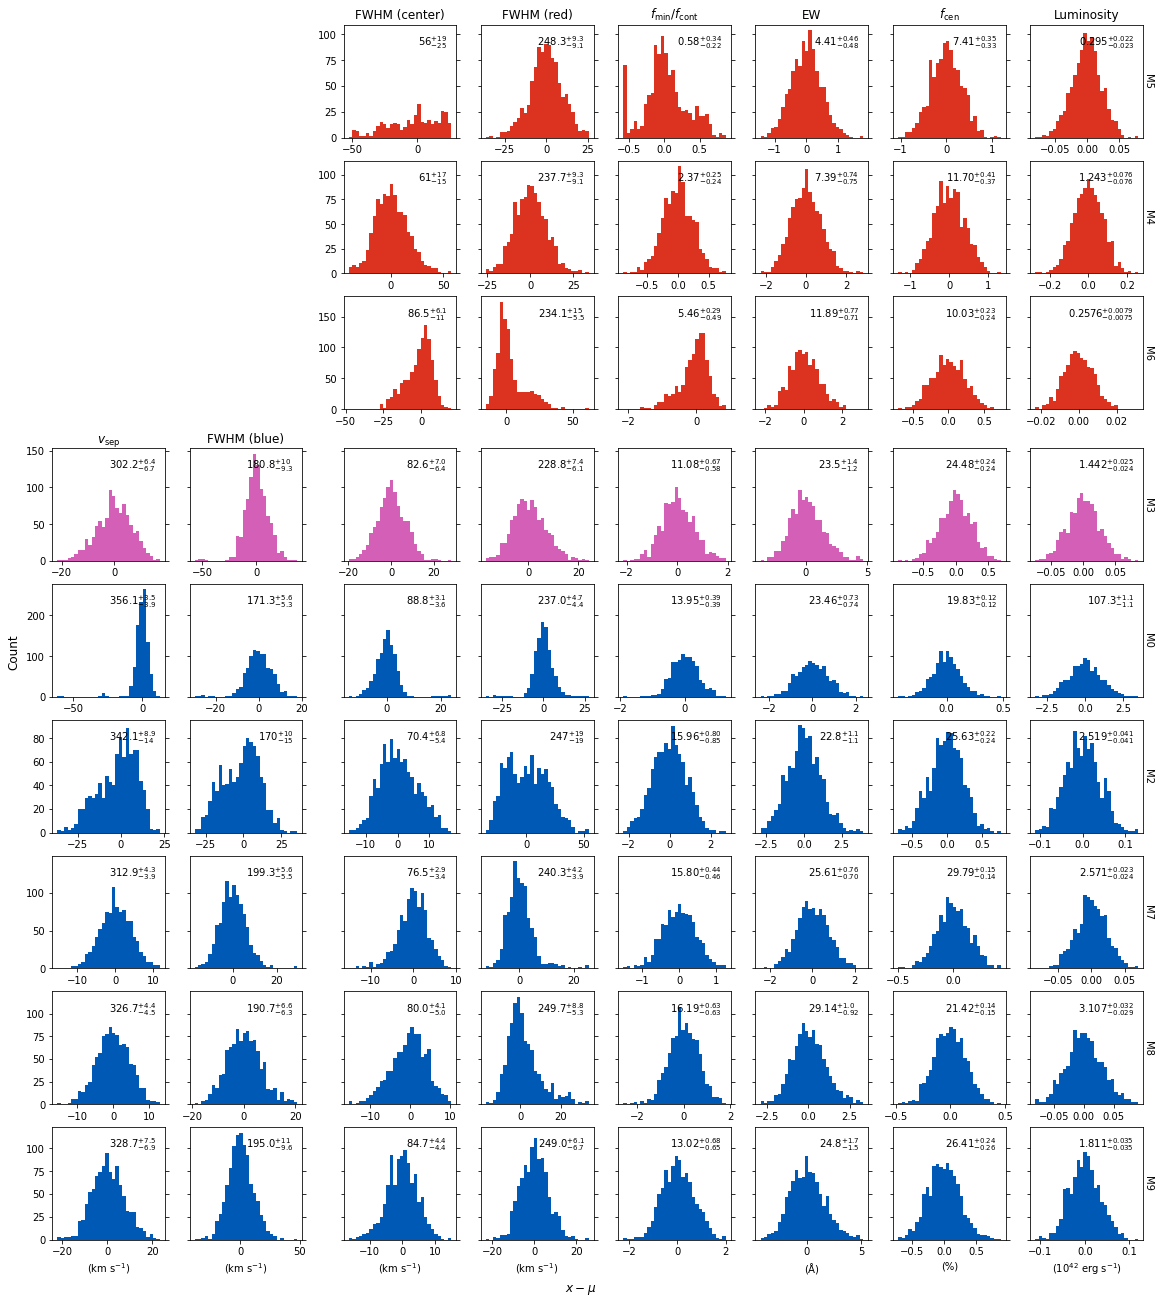

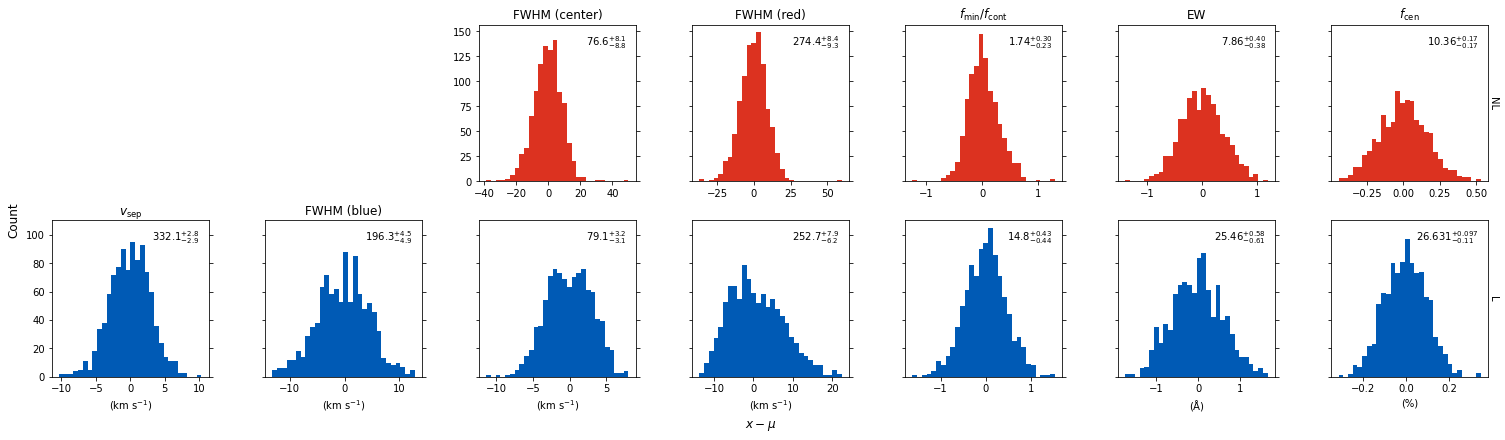

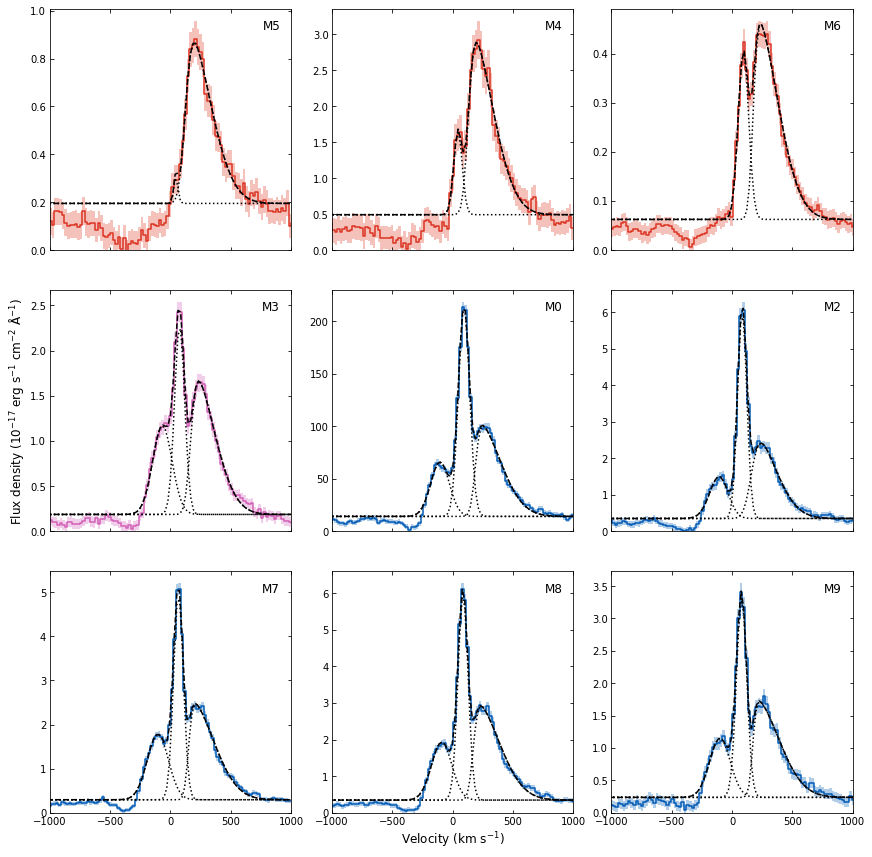

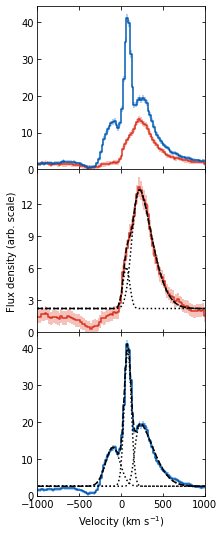

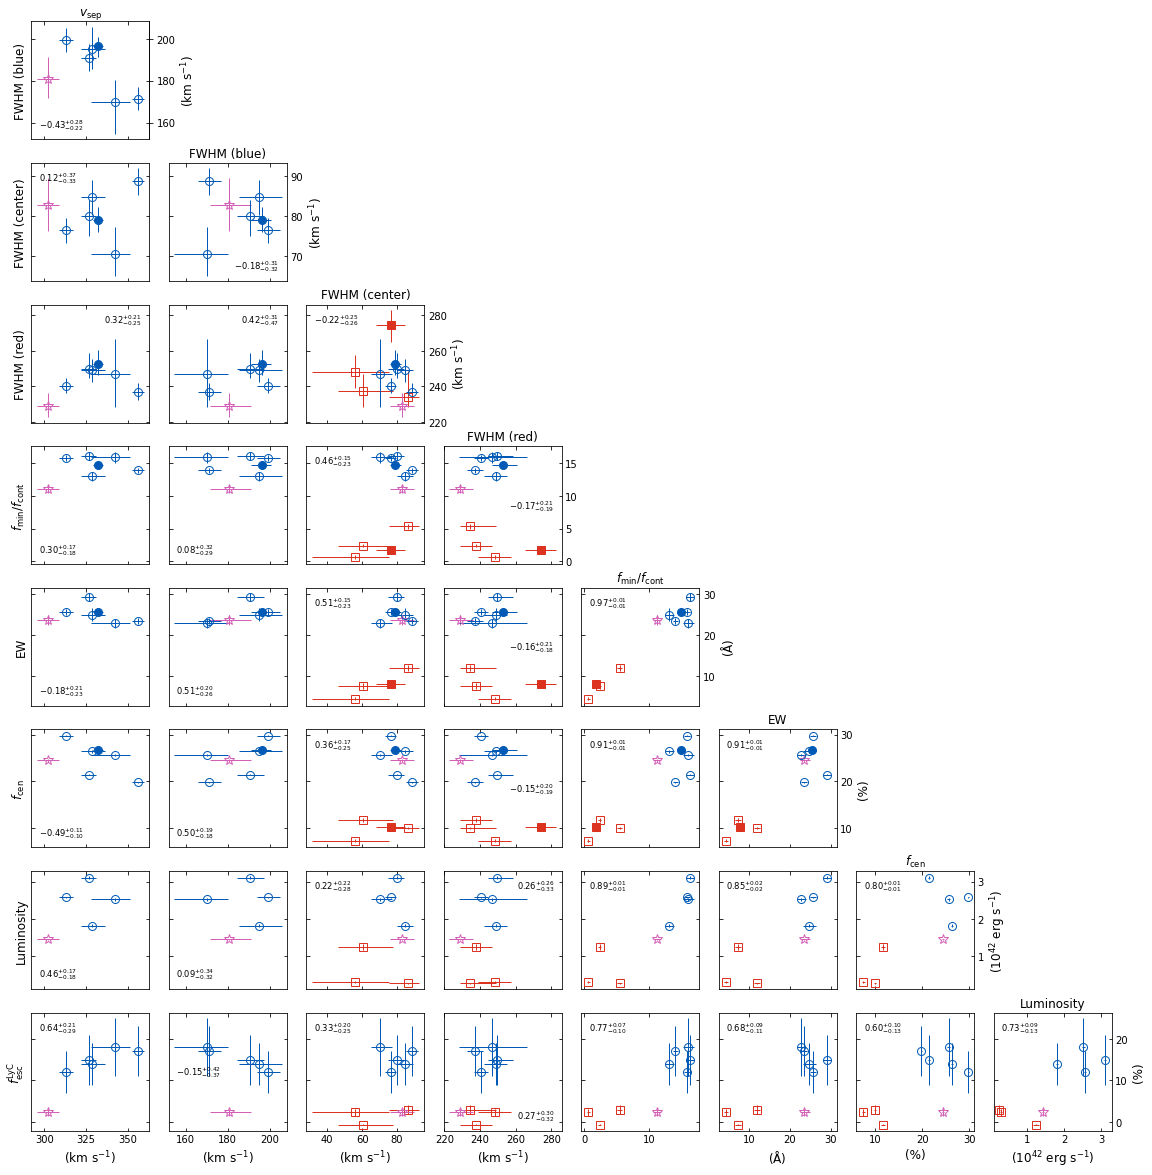

In [20]:
measure()